# Восстановление золота из руды

Модель предсказывает коэффициент восстановления золота из золотосодержащей руды.
Используются данные с параметрами добычи и очистки. 

Модель оптимизирует производство, анализируя предприятия с убыточными характеристиками.

## Подготовка данных

#### Импорт библиотек 

In [1560]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error

По умолчанию установим 1 знак после запятой для отобржения данных

In [1561]:
pd.options.display.float_format = '{:,.1f}'.format

### Откроем файлы и проанализируем

Данные находятся в трёх файлах:

- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

In [1562]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [1563]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.1,9.9,5.5,42.2,70.5,10.4,0.9,16.9,2.1,...,14.0,-502.5,12.1,-504.7,9.9,-498.3,8.1,-500.5,14.2,-605.8
1,2016-01-15 01:00:00,6.0,10.0,5.3,42.7,69.3,10.5,0.9,16.6,2.2,...,14.0,-505.5,12.0,-501.3,10.0,-500.2,8.0,-500.6,14.0,-599.8
2,2016-01-15 02:00:00,6.1,10.2,5.4,42.7,68.1,10.5,1.0,16.2,2.3,...,14.0,-502.5,11.9,-501.1,10.1,-500.1,8.0,-500.5,14.0,-601.4
3,2016-01-15 03:00:00,6.0,10.0,4.9,42.7,68.3,10.4,0.9,16.5,2.1,...,14.0,-500.9,12.0,-501.2,10.0,-499.2,8.0,-500.3,14.0,-600.0
4,2016-01-15 04:00:00,6.1,10.1,4.9,42.8,66.9,10.4,0.8,16.5,2.1,...,14.0,-499.8,12.0,-501.1,9.9,-501.7,7.9,-500.4,14.0,-601.5


In [1564]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.1,9.9,5.5,42.2,70.5,10.4,0.9,16.9,2.1,...,14.0,-502.5,12.1,-504.7,9.9,-498.3,8.1,-500.5,14.2,-605.8
1,2016-01-15 01:00:00,6.0,10.0,5.3,42.7,69.3,10.5,0.9,16.6,2.2,...,14.0,-505.5,12.0,-501.3,10.0,-500.2,8.0,-500.6,14.0,-599.8
2,2016-01-15 02:00:00,6.1,10.2,5.4,42.7,68.1,10.5,1.0,16.2,2.3,...,14.0,-502.5,11.9,-501.1,10.1,-500.1,8.0,-500.5,14.0,-601.4
3,2016-01-15 03:00:00,6.0,10.0,4.9,42.7,68.3,10.4,0.9,16.5,2.1,...,14.0,-500.9,12.0,-501.2,10.0,-499.2,8.0,-500.3,14.0,-600.0
4,2016-01-15 04:00:00,6.1,10.1,4.9,42.8,66.9,10.4,0.8,16.5,2.1,...,14.0,-499.8,12.0,-501.1,9.9,-501.7,7.9,-500.4,14.0,-601.5


In [1565]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.8,15.0,8.1,1.0,"1,399.0",-500.2,"1,399.1",-499.9,"1,400.1",...,12.0,-497.8,8.0,-501.3,7.9,-432.3,4.9,-500.0,26.7,-499.7
1,2016-09-01 01:59:59,215.4,15.0,8.1,1.0,"1,398.8",-500.1,"1,398.1",-499.8,"1,396.2",...,12.1,-498.7,8.1,-499.6,8.0,-525.8,4.9,-500.2,25.0,-499.8
2,2016-09-01 02:59:59,215.3,12.9,7.8,1.0,"1,398.5",-500.9,"1,398.9",-499.8,"1,398.1",...,12.0,-498.8,8.1,-500.8,8.1,-500.8,4.9,-499.8,25.0,-500.6
3,2016-09-01 03:59:59,215.3,12.0,7.6,0.9,"1,399.6",-498.9,"1,397.4",-499.2,"1,400.1",...,12.0,-498.4,8.1,-499.5,7.9,-500.9,4.9,-500.0,24.9,-498.7
4,2016-09-01 04:59:59,199.1,10.7,7.5,0.8,"1,401.3",-500.8,"1,398.1",-499.5,"1,402.2",...,12.0,-500.8,8.1,-500.4,8.1,-509.5,5.0,-500.4,25.0,-500.9


In [1566]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


#### Число строк в данных

In [1567]:
len(df_full['date'])

19439

In [1568]:
len(df_train['date'])

14149

In [1569]:
len(df_test['date'])

5290

#### Число пустых значений:

In [1570]:
df_full.isna().sum().sum()

4481

In [1571]:
df_train.isna().sum().sum()

4100

In [1572]:
df_test.isna().sum().sum()

90

#### Вывод:
- В данных есть пропуски значений.
- Данные уже разбиты обучающую и тестовую выборки в отношении примерно 3:1.
- В тестовой выборке на 34 колонки данных меньше.

### Проверим, что эффективность обогащения рассчитана правильно.
Вычислим её на обучающей выборке для признака **rougher.output.recovery**.

Расчёт эффективности

Эффективность обогащения рассчитывается по формуле

recovery = C * (F - T) / (F * (C - T)) * 100

где:

- C — доля золота в концентрате после флотации/очистки; ['rougher.output.concentrate_au']
- F — доля золота в сырье/концентрате до флотации/очистки; ['rougher.input.feed_au']
- T — доля золота в отвальных хвостах после флотации/очистки. ['rougher.output.tail_au']

In [1574]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [1575]:
recovery = C * (F - T) / (F * (C - T)) * 100

#### Найдем MAE между расчётами и значением признака.

In [1576]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery)
print("MAE между моими расчётами и значением признака rougher.output.recovery:", mae)

MAE между моими расчётами и значением признака rougher.output.recovery: 9.73512347450521e-15


#### Вывод по проверке:
Средняя абсолютная ошибка мала и составляет `0.00000000000000974` - считаем что расчеты `recovery` верны.

### Проанализируем признаки, недоступные в тестовой выборке.


Список признаков, недоступных в тестовой выборке:

In [1577]:
pd.Series(df_full.columns[np.invert(np.isin(df_full.columns, df_test.columns))])

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
17        rougher.calculation.sulfate_to_au_conc

#### Вывод по недоступным признакам:

В тестовой выборке нет этапов:

- rougher.output - выход грубой обработки
- rougher.calculation - выход грубой обработки
- primary_cleaner.output - выход первой очистки
- secondary_cleaner.output - выход второй очистки (хвосты)
- final.output - весь final 

`Поэтому`:
- Для обучения модели будем использовать только тип признака из тестовой выборки, иначе не сможем расчитать прогноз на тесте.
- Целевые признаки необходимо будет добавить в тестовую выборку из полных данных **`rougher.output.recovery`** и **`final.output.recovery`**.

### Предобработка данных.

Соседние по времени параметры часто похожи. Поэтому :

#### Добавим недостающие целевые признаки в тестовую выборку

`rougher.output.recovery` и `final.output.recovery`

In [1578]:
df_test = df_test.merge(df_full[['date','final.output.recovery','rougher.output.recovery']], on='date', how='left')
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.8,15.0,8.1,1.0,"1,399.0",-500.2,"1,399.1",-499.9,"1,400.1",...,8.0,-501.3,7.9,-432.3,4.9,-500.0,26.7,-499.7,70.3,90.0
1,2016-09-01 01:59:59,215.4,15.0,8.1,1.0,"1,398.8",-500.1,"1,398.1",-499.8,"1,396.2",...,8.1,-499.6,8.0,-525.8,4.9,-500.2,25.0,-499.8,68.9,88.1
2,2016-09-01 02:59:59,215.3,12.9,7.8,1.0,"1,398.5",-500.9,"1,398.9",-499.8,"1,398.1",...,8.1,-500.8,8.1,-500.8,4.9,-499.8,25.0,-500.6,68.1,88.4
3,2016-09-01 03:59:59,215.3,12.0,7.6,0.9,"1,399.6",-498.9,"1,397.4",-499.2,"1,400.1",...,8.1,-499.5,7.9,-500.9,4.9,-500.0,24.9,-498.7,67.8,87.4
4,2016-09-01 04:59:59,199.1,10.7,7.5,0.8,"1,401.3",-500.8,"1,398.1",-499.5,"1,402.2",...,8.1,-500.4,8.1,-509.5,5.0,-500.4,25.0,-500.9,61.5,83.2


#### Заменим пропуски на соседние значения в обучающей и тестовой выборках

In [1579]:
df_train = df_train.ffill()
df_test = df_test.ffill()

## Анализ данных

#### Технологический процесс
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

Описание данных

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Наименование признаков :

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

Расчёт эффективности
Необходимо смоделировать процесс восстановления золота из золотосодержащей руды.

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb)
на различных этапах очистки.

Посторим гистораммы концентрации для каждого металла на различных стадиях.

####  Au гисторамма концентрации на различных стадиях. 

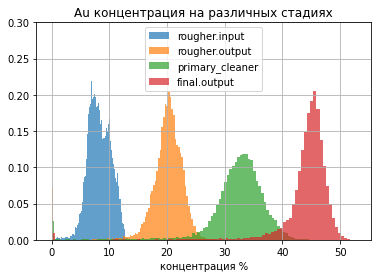

In [1581]:
df_full['rougher.input.feed_au'].hist(bins =100, alpha=0.7, label='rougher.input', density=True)
df_full['rougher.output.concentrate_au'].hist(bins =100, alpha=0.7, label='rougher.output', density=True)
df_full['primary_cleaner.output.concentrate_au'].hist(bins =100, alpha=0.7, label='primary_cleaner', density=True)
df_full['final.output.concentrate_au'].hist(bins =100, alpha=0.7, label='final.output', density=True)

plt.xlabel('концентрация %')
plt.title('Au концентрация на различных стадиях')
plt.legend()

plt.ylim([0, 0.3])

plt.show()

####  Ag гисторамма концентрации на различных стадиях. 

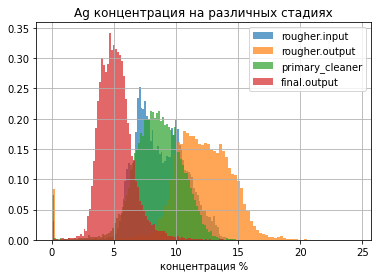

In [1582]:
df_full['rougher.input.feed_ag'].hist(bins =100, alpha=0.7, label='rougher.input', density=True)
df_full['rougher.output.concentrate_ag'].hist(bins =100, alpha=0.7, label='rougher.output', density=True)
df_full['primary_cleaner.output.concentrate_ag'].hist(bins =100, alpha=0.7, label='primary_cleaner', density=True)
df_full['final.output.concentrate_ag'].hist(bins =100, alpha=0.7, label='final.output', density=True)

plt.xlabel('концентрация %')
plt.title('Ag концентрация на различных стадиях')
plt.legend()

plt.show()

####  Pb гисторамма концентрации на различных стадиях. 

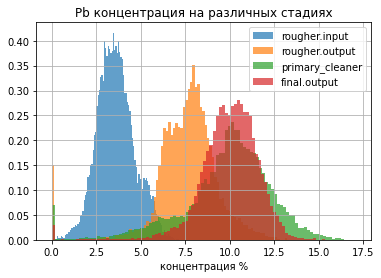

In [1583]:
df_full['rougher.input.feed_pb'].hist(bins =100, alpha=0.7, label='rougher.input', density=True)
df_full['rougher.output.concentrate_pb'].hist(bins =100, alpha=0.7, label='rougher.output', density=True)
df_full['primary_cleaner.output.concentrate_pb'].hist(bins =100, alpha=0.7, label='primary_cleaner', density=True)
df_full['final.output.concentrate_pb'].hist(bins =100, alpha=0.7, label='final.output', density=True)

plt.xlabel('концентрация %')
plt.title('Pb концентрация на различных стадиях')
plt.legend()

plt.show()

#### Вывод по изменению концентрации металлов (Au, Ag, Pb):

- Доля Au значительно вырастает на финальном этапе с 8 до 44%
- Доля Ag снижается.
- Доля Pb растет.

### Сравним распределения размеров гранул сырья 
на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Этап Флотации

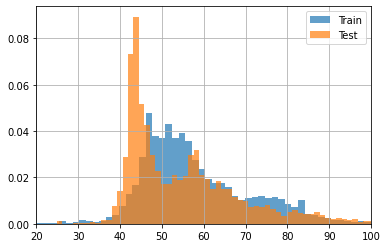

In [1584]:
df_train['rougher.input.feed_size'].hist(bins=300, label='Train', density=True, alpha=0.7)
df_test['rougher.input.feed_size'].hist(bins=300, label='Test', density=True, alpha=0.7)
plt.xlim([20, 100])
plt.legend()

Этап первичной очистки:

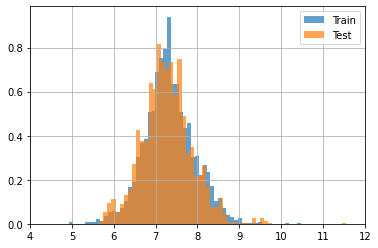

In [1585]:
df_train['primary_cleaner.input.feed_size'].hist(bins=100, label='Train', density=True, alpha=0.7)
df_test['primary_cleaner.input.feed_size'].hist(bins=100, label='Test', density=True, alpha=0.7)
plt.xlim([4, 12])
plt.legend()

#### Вывод по распределению размеров гранул сырья:
- распределение гранул отличается но не значительно.
- После этапа Флотации размер гранул уменьшается 7-8 раз и становится равномерным, можно сказать что на этапе флотации происходит дробление гранул до среднего размера 7 мм.

### Исследуем суммарную концентрацию всех веществ
на разных стадиях: в сырье, в черновом и финальном концентратах.

Создадим Series с суммарной концентрацией всех веществ на различных стадиях:

In [1586]:
rougher_input = (df_full['rougher.input.feed_ag'] + 
                 df_full['rougher.input.feed_pb'] +
                 df_full['rougher.input.feed_au'] +
                 df_full['rougher.input.feed_sol'])

In [1587]:
rougher_output = (df_full['rougher.output.concentrate_ag'] + 
                  df_full['rougher.output.concentrate_pb'] +
                  df_full['rougher.output.concentrate_sol'] +
                  df_full['rougher.output.concentrate_au'])

In [1588]:
primary_cleaner_output = (df_full['primary_cleaner.output.concentrate_ag'] + 
                          df_full['primary_cleaner.output.concentrate_pb'] +
                          df_full['primary_cleaner.output.concentrate_sol'] +
                          df_full['primary_cleaner.output.concentrate_au'])

In [1589]:
final_output = (df_full['final.output.concentrate_ag'] + 
                df_full['final.output.concentrate_pb'] +
                df_full['final.output.concentrate_sol'] +
                df_full['final.output.concentrate_au'])

Построим гистограмму:

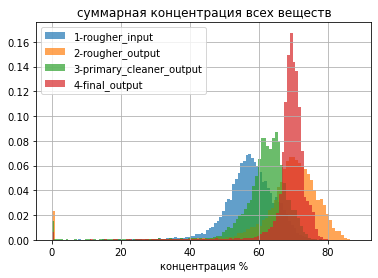

In [1590]:
rougher_input.hist(bins =100, alpha=0.7, label='1-rougher_input', density=True)
rougher_output.hist(bins =100, alpha=0.7, label='2-rougher_output', density=True)
primary_cleaner_output.hist(bins =100, alpha=0.7, label='3-primary_cleaner_output', density=True)
final_output.hist(bins =100, alpha=0.7, label='4-final_output', density=True)
plt.xlabel('концентрация %')
plt.title('суммарная концентрация всех веществ')

plt.legend()

#### Удалим анамалии около нуля.

Train DataFrame:

In [1591]:
df_train = df_train.loc[df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_pb'] +
                        df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_sol'] != 0]

In [1592]:
df_train = df_train.loc[df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb'] +
                        df_train['rougher.output.concentrate_sol'] + df_train['rougher.output.concentrate_au'] != 0]

In [1593]:
df_train = df_train.loc[df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_pb'] +
                        df_train['primary_cleaner.output.concentrate_sol'] + df_train['primary_cleaner.output.concentrate_au'] != 0]

In [1594]:
df_train = df_train.loc[df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb'] +
                        df_train['final.output.concentrate_sol'] + df_train['final.output.concentrate_au'] != 0]

Test DataFrame:

In [1595]:
df_test = df_test.loc[df_test['rougher.input.feed_ag'] + df_test['rougher.input.feed_pb'] +
                        df_test['rougher.input.feed_au'] + df_test['rougher.input.feed_sol'] != 0]

#### Вывод:
Суммарная концентрация растет и уменьшается разброс значений.

## Модель

### Функция для вычисления итоговой sMAPE.

In [1597]:
def smape(target, predict):
    target = np.array(target) # выравниваем индексы
    predict = np.array(predict) # выравниваем индексы
    
    smape = abs(target - predict) / ((abs(target) + abs(predict)) / 2) # содаем массив i-результатов
            
    smape = np.nan_to_num(smape) # заменяем NaN (от деления на 0) на значение 0. Если y_true = y_pred = 0 то и sMAPE = 0.
    smape = smape.mean() * 100 # вычисляем среднее
    
    return smape

#### Кастомная функция оценки модели (make_scorer)

In [1598]:
smape_scorer = make_scorer(smape)

### Обучим разные модели
и оценим их качество кросс-валидацией. 

#### Зададим число блоков кросс-валидации

In [1599]:
CV = 5

#### sMAPE(rougher) Train

##### Rougher: выделим признаки обучающей выборки

In [1600]:
features_train_rougher = df_train[['rougher.input.feed_ag',
'rougher.input.feed_pb',
'rougher.input.feed_rate',
'rougher.input.feed_size',
'rougher.input.feed_sol',
'rougher.input.feed_au',
'rougher.input.floatbank10_sulfate',
'rougher.input.floatbank10_xanthate',
'rougher.input.floatbank11_sulfate',
'rougher.input.floatbank11_xanthate',]]

##### Rougher: выделим целевой признак обучающей выборки

In [1601]:
target_train_rougher = df_train['rougher.output.recovery']

##### LinearRegression

In [1602]:
model = LinearRegression()
smape_train_rougher = cross_val_score(model, features_train_rougher, target_train_rougher, scoring=smape_scorer, cv=CV).mean()
print("LinearRegression sMAPE: {:.2f}".format(smape_train_rougher))

LinearRegression sMAPE: 6.60


##### DecisionTreeRegressor

In [1603]:
%%time

smape_best = 10000
best_depth = 0
for depth in range (1, 4, 1):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)# с параметрами random_state=12345 и max_depth=depth
    result = cross_val_score(model, features_train_rougher, target_train_rougher, scoring=smape_scorer, cv=CV).mean()
    if result < smape_best:
        smape_best = result
        best_depth = depth

print("DecisionTreeRegressor sMAPE: {:.2f}".format(smape_best))
print('best_depth', best_depth)
print()

DecisionTreeRegressor sMAPE: 6.72
best_depth 3

CPU times: user 548 ms, sys: 12.1 ms, total: 560 ms
Wall time: 898 ms


##### RandomForestRegressor

In [1604]:
%%time

smape_best = 10000
best_est = 0
best_depth = 0
for est in range(1, 4, 1): #подбор гиперпараметра n_estimators
    for depth in range (1, 4, 1): #подбор гиперпараметра max_depth
        model = RandomForestRegressor(random_state=12345, n_estimators=est,
                max_depth=depth)# модель RandomForestRegressor
        result = cross_val_score(model, features_train_rougher, target_train_rougher, scoring=smape_scorer, cv=CV).mean()
        if result < smape_best:
            smape_best = result
            best_est = est
            best_depth = depth

print("RandomForestRegressor sMAPE: {:.2f}".format(smape_best))
print('best_est', best_est)
print('best_depth', best_depth)
print()

RandomForestRegressor sMAPE: 6.80
best_est 3
best_depth 3

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.08 s


##### Вывод sMAPE(rougher) Train

Наименьшую ошибку показывает модель model **`LinearRegression`** sMAPE: 6.60.

#### sMAPE(final) Train

##### Final: выделим признаки обучающей выборки

In [1605]:
features_train_final = df_train[['secondary_cleaner.state.floatbank2_a_air',
'secondary_cleaner.state.floatbank2_a_level',
'secondary_cleaner.state.floatbank2_b_air',
'secondary_cleaner.state.floatbank2_b_level',
'secondary_cleaner.state.floatbank3_a_air',
'secondary_cleaner.state.floatbank3_a_level',
'secondary_cleaner.state.floatbank3_b_air',
'secondary_cleaner.state.floatbank3_b_level',
'secondary_cleaner.state.floatbank4_a_air',
'secondary_cleaner.state.floatbank4_a_level',
'secondary_cleaner.state.floatbank4_b_air',
'secondary_cleaner.state.floatbank4_b_level',
'secondary_cleaner.state.floatbank5_a_air',
'secondary_cleaner.state.floatbank5_a_level',
'secondary_cleaner.state.floatbank5_b_air',
'secondary_cleaner.state.floatbank5_b_level',
'secondary_cleaner.state.floatbank6_a_air',
'secondary_cleaner.state.floatbank6_a_level']]

##### Final: выделим целевой признак обучающей выборки

In [1606]:
target_train_final = df_train['final.output.recovery']

##### LinearRegression

In [1607]:
model = LinearRegression()
smape_train_final = cross_val_score(model, features_train_final, target_train_final, scoring=smape_scorer, cv=CV).mean()
print("LinearRegression sMAPE: {:.2f}".format(smape_train_final))

LinearRegression sMAPE: 10.13


##### DecisionTreeRegressor

In [1608]:
%%time

smape_best = 10000
best_depth = 0
for depth in range (1, 4, 1):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)# с параметрами random_state=12345 и max_depth=depth
    result = cross_val_score(model, features_train_final, target_train_final, scoring=smape_scorer, cv=CV).mean()
    if result < smape_best:
        smape_best = result
        best_depth = depth

print("DecisionTreeRegressor sMAPE: {:.2f}".format(smape_best))
print('best_depth', best_depth)
print()

DecisionTreeRegressor sMAPE: 10.60
best_depth 1

CPU times: user 960 ms, sys: 20.1 ms, total: 980 ms
Wall time: 992 ms


##### RandomForestRegressor

In [1609]:
%%time

smape_best = 10000
best_est = 0
best_depth = 0
for est in range(1, 4, 1):
    for depth in range (1, 4, 1):
        model = RandomForestRegressor(random_state=12345, n_estimators=est,
                max_depth=depth)# инициализируем модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
        result = cross_val_score(model, features_train_final, target_train_final, scoring=smape_scorer, cv=CV).mean()
        if result < smape_best:
            smape_best = result
            best_est = est
            best_depth = depth

print("RandomForestRegressor sMAPE: {:.2f}".format(smape_best))
print('best_est', best_est)
print('best_depth', best_depth)
print()

RandomForestRegressor sMAPE: 10.51
best_est 3
best_depth 1

CPU times: user 3.28 s, sys: 7.93 ms, total: 3.29 s
Wall time: 3.3 s


##### Вывод sMAPE(final) Train

Наименьшую ошибку показывает модель model **`LinearRegression`** sMAPE: `10.13` .

#### Итоговый sMAPE Train:

In [1611]:
total_smape_train = 0.25 * smape_train_rougher + 0.75 * smape_train_final

print("Итоговый sMAPE train: {:.2f}".format(total_smape_train))

Итоговый sMAPE train: 9.25


### Возьмем лучшую модель и проверим её на тестовой выборке. 

Лучшей моделью на обоих этапах выбрана **`LinearRegression`**.

#### sMAPE(rougher) Test

##### Rougher: выделим признаки тестовой выборки

In [1612]:
features_test_rougher = df_test[['rougher.input.feed_ag',
'rougher.input.feed_pb',
'rougher.input.feed_rate',
'rougher.input.feed_size',
'rougher.input.feed_sol',
'rougher.input.feed_au',
'rougher.input.floatbank10_sulfate',
'rougher.input.floatbank10_xanthate',
'rougher.input.floatbank11_sulfate',
'rougher.input.floatbank11_xanthate',]]

##### Rougher: выделим целевой признак тестовой выборки

In [1613]:
target_test_rougher = df_test['rougher.output.recovery']

##### Расчет sMAPE на этапе rougher для тестовой выборки по лучшей модели 

In [1614]:
model = LinearRegression() # инициализируем модель LinearRegression

model.fit(features_train_rougher, target_train_rougher) # обучим модель на тренировочной выборке
predictions_test_rougher = model.predict(features_test_rougher) # предсказания модели на валидационной выборке

smape_test_rougher = smape(target_test_rougher, predictions_test_rougher)

print("sMAPE(rougher) Test: {:.2f}".format(smape_test_rougher))

sMAPE(rougher) Test: 7.94


#### sMAPE(final) Test

##### Final: выделим признаки тестовой выборки

In [1615]:
features_test_final = df_test[['secondary_cleaner.state.floatbank2_a_air',
'secondary_cleaner.state.floatbank2_a_level',
'secondary_cleaner.state.floatbank2_b_air',
'secondary_cleaner.state.floatbank2_b_level',
'secondary_cleaner.state.floatbank3_a_air',
'secondary_cleaner.state.floatbank3_a_level',
'secondary_cleaner.state.floatbank3_b_air',
'secondary_cleaner.state.floatbank3_b_level',
'secondary_cleaner.state.floatbank4_a_air',
'secondary_cleaner.state.floatbank4_a_level',
'secondary_cleaner.state.floatbank4_b_air',
'secondary_cleaner.state.floatbank4_b_level',
'secondary_cleaner.state.floatbank5_a_air',
'secondary_cleaner.state.floatbank5_a_level',
'secondary_cleaner.state.floatbank5_b_air',
'secondary_cleaner.state.floatbank5_b_level',
'secondary_cleaner.state.floatbank6_a_air',
'secondary_cleaner.state.floatbank6_a_level']]

In [1616]:
target_test_final = df_test['final.output.recovery']

##### Расчет sMAPE на этапе final для тестовой выборки по лучшей модели 

In [1617]:
model = LinearRegression() # инициализируем модель LinearRegression
model.fit(features_train_final, target_train_final) # обучим модель на тренировочной выборке
predictions_test_final = model.predict(features_test_final) # предсказания модели на валидационной выборке

smape_test_final = smape(target_test_final, predictions_test_final)

print("sMAPE(rougher): {:.2f}".format(smape_test_final))

sMAPE(rougher): 12.16


#### Итоговый sMAPE Test:

In [1619]:
total_smape_test = 0.25 * smape_test_rougher + 0.75 * smape_test_final

print("Итоговый sMAPE test: {:.2f}".format(total_smape_test))

Итоговый sMAPE test: 11.11


### Выводы.

Подготовлен прототип модели машинного обучения. Модель предсказывает коэффициент восстановления золота из золотосодержащей руды.

Методом кросс-валидации на обучающей выборке было протестировано 3 модели регрессии на 2-х этапах. Лучший результат показала **`линейная регрессия`**.


Ошибка предсказания **`Итоговое sMAPE`** «симметричное среднее абсолютное процентное отклонение» составляет : **`11.11 % `**.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.